In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import torch.nn as nn
from layers.customLayer import CustomLayer
from training.train import TrainUtil
from metrics.charts import ChartUtil
from metrics.charts import TrainingCharts, TestCharts
from datasets.xor import XOR

In [17]:
dataset = XOR()
in_features = 4
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = True)

In [ ]:
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)


In [19]:
# Width, depth and which layers the sparsity is applied to -> Try with a binary search on these 
# Similar number of parameters
# Where does the sparsity help? -> check combinations

In [29]:

def get_models(first_layer_out_features = 200,
first_layer_out_percentage_allowed = 0.075,
second_layer_out_features = 250,
second_layer_out_percentage_allowed = 0.08,
third_layer_out_features = 200,
third_layer_out_percentage_allowed = 0.05,
model_type = None,
print_model_summary = False,
in_features = 2):
    
    first_layer_out_features_allowed = int(first_layer_out_features * first_layer_out_percentage_allowed)
    second_layer_out_features_allowed = int(second_layer_out_features * second_layer_out_percentage_allowed )
    third_layer_out_features_allowed = int(third_layer_out_features * third_layer_out_percentage_allowed)
    
    if print_model_summary:
        print(f"First Layer: {first_layer_out_features} neurons, {first_layer_out_features_allowed} allowed")
        print(f"Second Layer: {second_layer_out_features} neurons, {second_layer_out_features_allowed} allowed")
        print(f"Third Layer: {third_layer_out_features} neurons, {third_layer_out_features_allowed} allowed")

    class SimpleSparseModel(nn.Module):
        def __init__(self, in_features = in_features, out_features = 2):
            super().__init__()
            self._layer1 = CustomLayer(in_features, 
                                            first_layer_out_features, 
                                            out_features_allowed=first_layer_out_features_allowed)
            self._layer2 = CustomLayer(first_layer_out_features, 
                                            second_layer_out_features, 
                                            out_features_allowed=second_layer_out_features_allowed)
            self._layer3 = CustomLayer(second_layer_out_features, 
                                            third_layer_out_features, 
                                            out_features_allowed=third_layer_out_features_allowed)
            self._layer4 = CustomLayer(third_layer_out_features, out_features)

        def forward(self, x, return_acts = False):
            x_l1 = self._layer1(x)
            x_l2 = self._layer2(x_l1)
            x_l3 = self._layer3(x_l2)
            out = self._layer4(x_l3)
            if return_acts:
                return out, {"l1": x_l1, "l2": x_l2, "l3": x_l3, "l4": out}
            return out
        
    class SimpleControlModel(nn.Module):
        def __init__(self, in_features = in_features, out_features = 2):
            super().__init__()
            self._layer1 = CustomLayer(in_features, first_layer_out_features_allowed)
            self._layer2 = CustomLayer(first_layer_out_features_allowed, second_layer_out_features_allowed)
            self._layer3 = CustomLayer(second_layer_out_features_allowed, third_layer_out_features_allowed)
            self._layer4 = CustomLayer(third_layer_out_features_allowed, out_features)

        def forward(self, x, return_acts = False):
            x_l1 = self._layer1(x)
            x_l2 = self._layer2(x_l1)
            x_l3 = self._layer3(x_l2)
            out = self._layer4(x_l3)
            if return_acts:
                return out, {"l1": x_l1, "l2": x_l2, "l3": x_l3, "l4": out}
            return out
        
    class SimpleDenseModel(nn.Module):
        def __init__(self, in_features = in_features, out_features = 2):
            super().__init__()
            self._layer1 = CustomLayer(in_features, first_layer_out_features)
            self._layer2 = CustomLayer(first_layer_out_features, second_layer_out_features)
            self._layer3 = CustomLayer(second_layer_out_features,third_layer_out_features)
            self._layer4 = CustomLayer(third_layer_out_features, out_features)
            nn.Linear(in_features, out_features).forward
            self.net = nn.Sequential(
                self._layer1,
                self._layer2,
                self._layer3,
                self._layer4
            )

        def forward(self, x):
            return self.net(x)
    if model_type == "sparse":
        return SimpleSparseModel()
    elif model_type == "control":
        return SimpleControlModel()
    elif model_type == "dense":
        return SimpleDenseModel()
    else:
        return SimpleSparseModel(), SimpleControlModel(), SimpleDenseModel()

In [30]:
def perform_one_experiment(n_epochs = 41, 
                          n_runs=60,
                          first_layer_out_features = 200,
                          first_layer_out_percentage_allowed = 0.075,
                          second_layer_out_features = 250,
                          second_layer_out_percentage_allowed = 0.08,
                          third_layer_out_features = 200,
                          third_layer_out_percentage_allowed = 0.05,
                          print_summary = False,
                          trainUtil = trainUtil,
                          in_features = in_features,):
    chartUtil = ChartUtil()
    epoch_num = n_epochs
    for _ in range(n_runs):
        simpleSparseModel, simpleControlModel, simpleDenseModel = get_models(first_layer_out_features = first_layer_out_features,
                                                        first_layer_out_percentage_allowed = first_layer_out_percentage_allowed,
                                                        second_layer_out_features = second_layer_out_features,
                                                        second_layer_out_percentage_allowed = second_layer_out_percentage_allowed,
                                                        third_layer_out_features = third_layer_out_features,
                                                        third_layer_out_percentage_allowed = third_layer_out_percentage_allowed,
                                                        print_model_summary = print_summary,
                                                        in_features = in_features)
        simpleSparseOrthoModel = get_models(model_type="sparse",
                                            first_layer_out_features = first_layer_out_features,
                                            first_layer_out_percentage_allowed = first_layer_out_percentage_allowed,
                                            second_layer_out_features = second_layer_out_features,
                                            second_layer_out_percentage_allowed = second_layer_out_percentage_allowed,
                                            third_layer_out_features = third_layer_out_features,
                                            third_layer_out_percentage_allowed = third_layer_out_percentage_allowed,
                                            print_model_summary = print_summary,
                                            in_features = in_features)
        
        loss_over_epochs, accuracy_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleSparseModel, 
                                                                                                                           epochs=epoch_num, 
                                                                                                                           name="Sparse Model",
                                                                                                                           print_msg=print_summary)
        chartUtil.add_train_data("Sparse Model", loss_over_epochs, accuracy_over_epochs, epoch_numbers)
        chartUtil.add_test_data("Sparse Model", train_accuracy, val_accuracy)

        loss_over_epochs, accuracy_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleSparseOrthoModel,
                                                                                                                           epochs=epoch_num, 
                                                                                                                           name="Sparse Ortho Model", 
                                                                                                                           ortho_lambda=0.1,
                                                                                                                           print_msg=print_summary)
        chartUtil.add_train_data("Sparse Ortho Model", loss_over_epochs, accuracy_over_epochs, epoch_numbers)
        chartUtil.add_test_data("Sparse Ortho Model", train_accuracy, val_accuracy)

        loss_over_epochs, accuracy_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleControlModel, 
                                                                                                                           epochs=epoch_num, 
                                                                                                                           name="Control Model",
                                                                                                                           print_msg=print_summary)
        chartUtil.add_train_data("Control Model", loss_over_epochs, accuracy_over_epochs, epoch_numbers)
        chartUtil.add_test_data("Control Model", train_accuracy, val_accuracy)

        loss_over_epochs, accuracy_over_epochs, epoch_numbers, train_accuracy, val_accuracy = trainUtil.train_and_evaluate(simpleDenseModel, 
                                                                                                                           epochs=epoch_num, 
                                                                                                                           name="Dense Model",
                                                                                                                           print_msg=print_summary)
        chartUtil.add_train_data("Dense Model", loss_over_epochs, accuracy_over_epochs, epoch_numbers)
        chartUtil.add_test_data("Dense Model", train_accuracy, val_accuracy)
    
    return chartUtil

In [38]:
in_features = [2, 4, 6, 8]
trainUtils = []
chartUtils = []
for i in in_features:
    dataset = XOR()
    X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = i, unique = True)
    newTrainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)
    trainUtils.append(newTrainUtil)
    chartUtil = perform_one_experiment(n_epochs= 500, trainUtil=newTrainUtil, in_features = i)
    chartUtils.append(chartUtil)

In [39]:
combinedCharts = chartUtils[0]
for i in range(1, len(in_features)):
    combinedCharts = combinedCharts.combine_charts(chartUtils[i], suffix=f" {in_features[i]}")

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_65310/1628439170.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  training_loss.show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_65310/1628439170.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  training_acc.show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_65310/1628439170.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  test_acc.show()


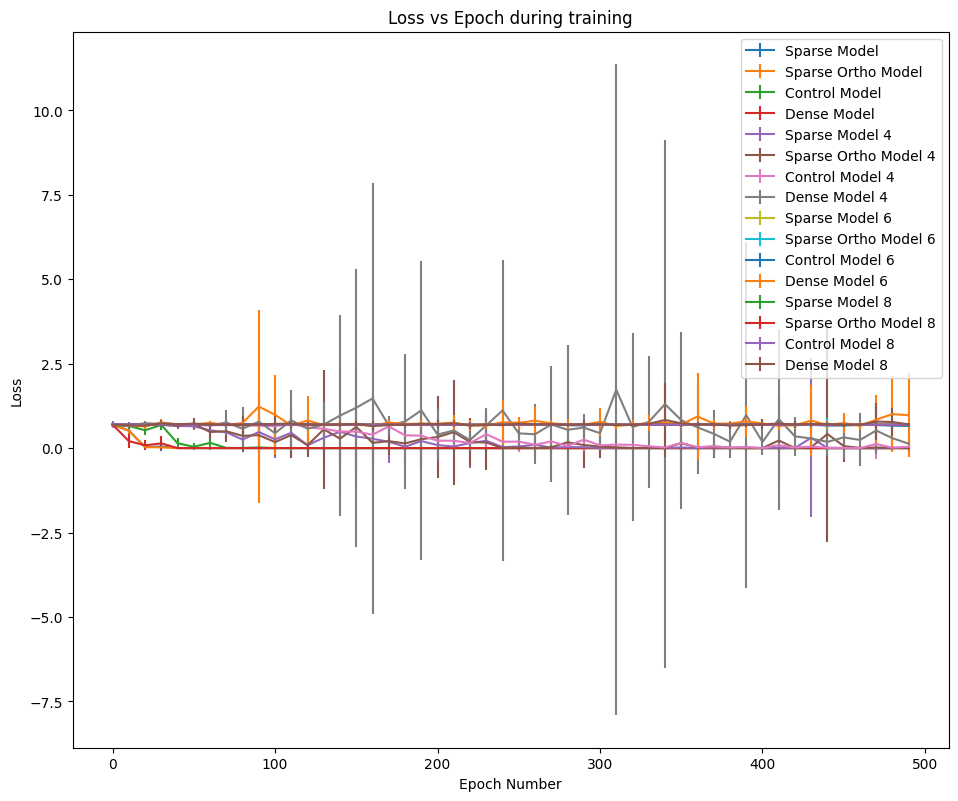

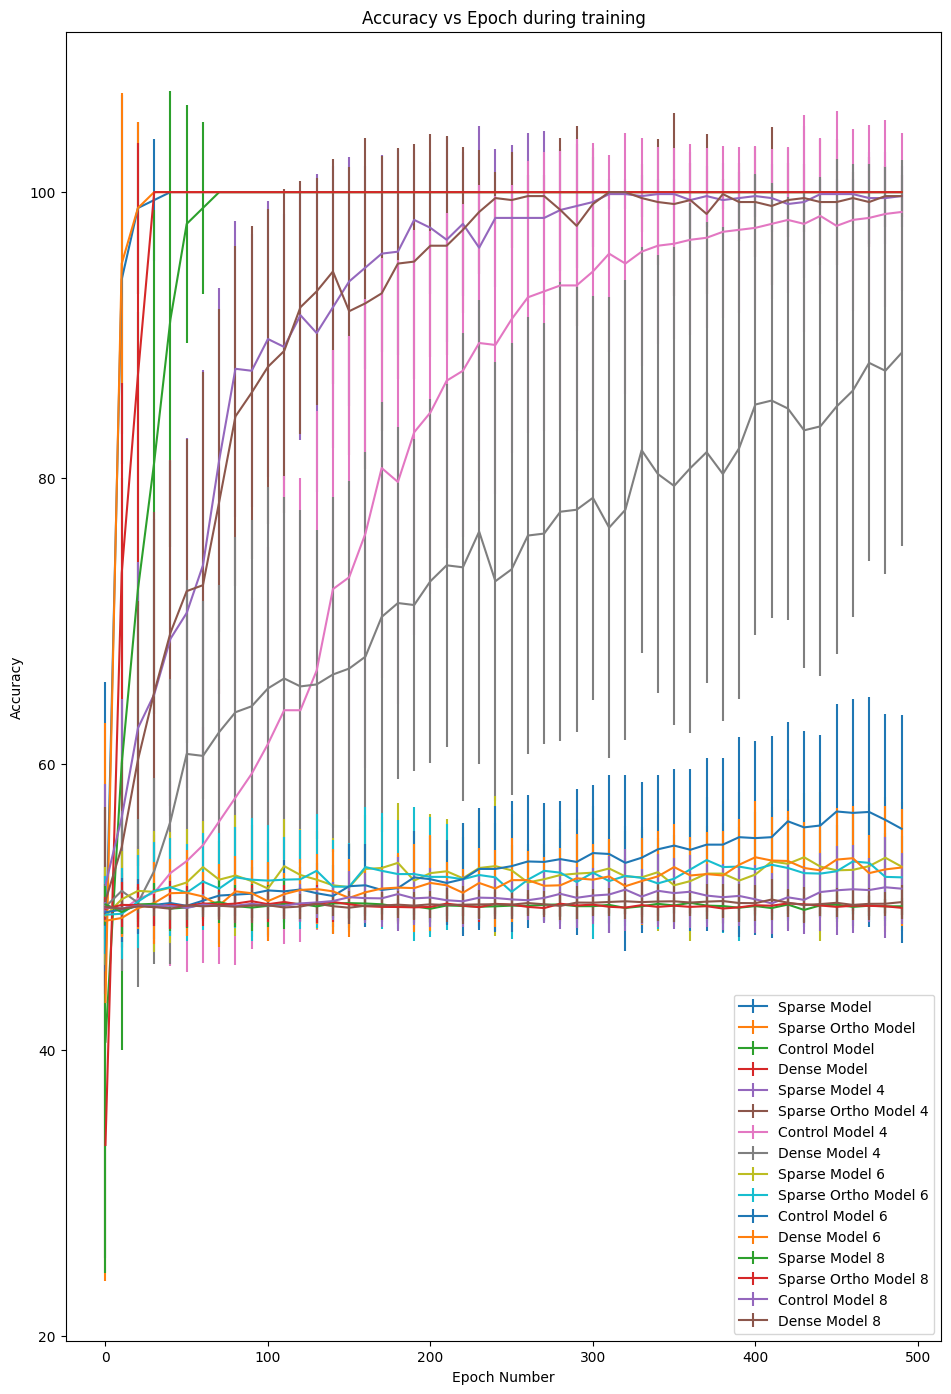

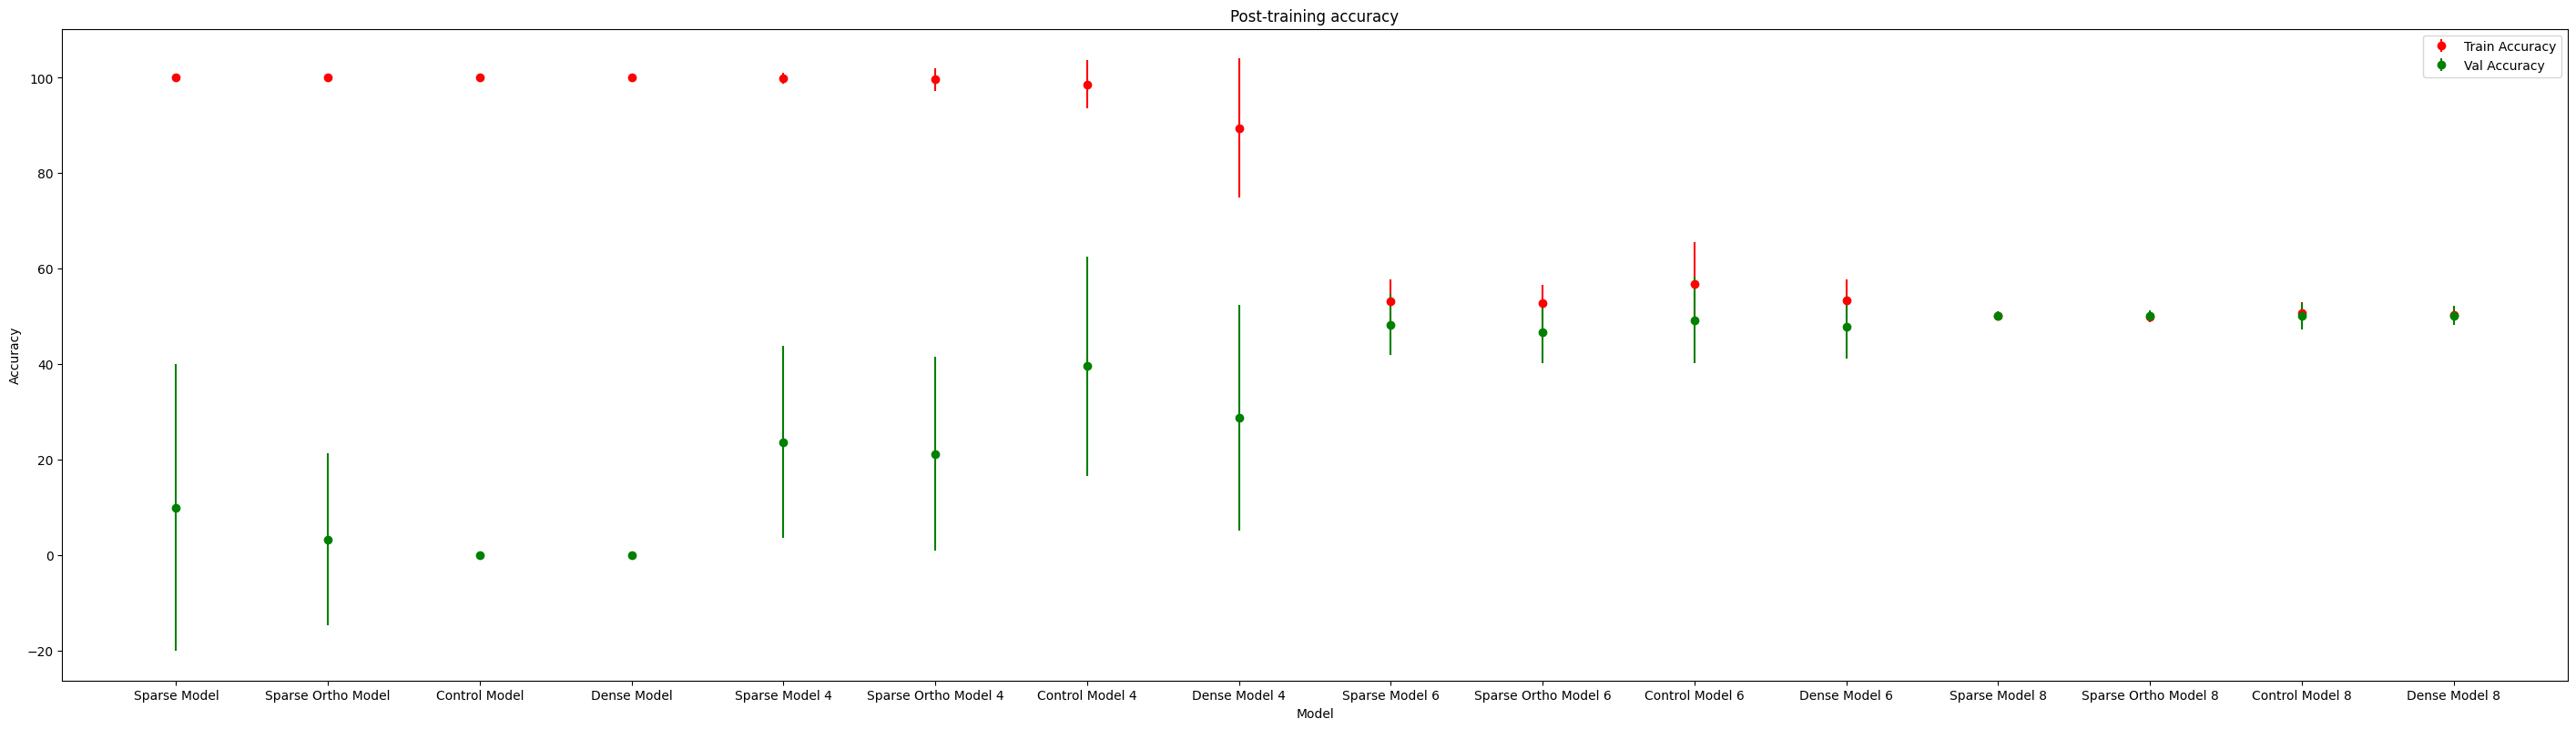

In [44]:
training_loss = combinedCharts.plot_training_data_for()
training_acc = combinedCharts.plot_training_data_for(TrainingCharts.ACC, height_alpha=1)
test_acc = combinedCharts.plot_test_accu_for_models(width_alpha=2.5)
training_loss.show()
training_acc.show()
test_acc.show()

In [ ]:
model1Final = chartUtil.data["test"]["Sparse Ortho Model"][TestCharts.TRAIN_ACC]
model2Final = chartUtil.data["test"]["Sparse Model"][TestCharts.TRAIN_ACC]
np.mean(model1Final), np.std(model1Final), np.mean(model2Final), np.std(model2Final)

(np.float64(95.81666628519694),
 np.float64(8.830802325995004),
 np.float64(96.21666640043259),
 np.float64(9.40583496503897))

In [ ]:
n_percentages = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
chart_utils = {}
for i in n_percentages:
    chart_utils[i] = perform_one_experiment(first_layer_out_percentage_allowed=i,
                                            second_layer_out_percentage_allowed=i,
                                            third_layer_out_percentage_allowed=i,
                                            print_summary=False)

In [77]:
combined_charts = chart_utils[n_percentages[0]]
for i in n_percentages[1:]:
    combined_charts = combined_charts.combine_charts(chart_utils[i], suffix=f" {i}")

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42824/1153898666.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_training_data_for(models=sparse_models).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42824/1153898666.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_training_data_for(TrainingCharts.ACC, models=sparse_models).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42824/1153898666.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_test_accu_for_models(models=sparse_models, width_alpha=2.5).show()


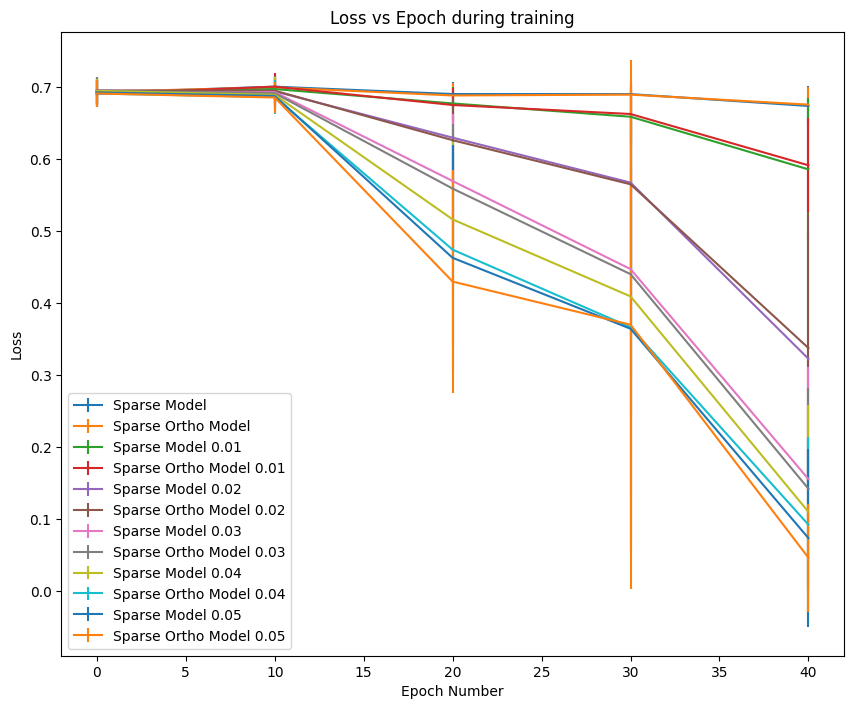

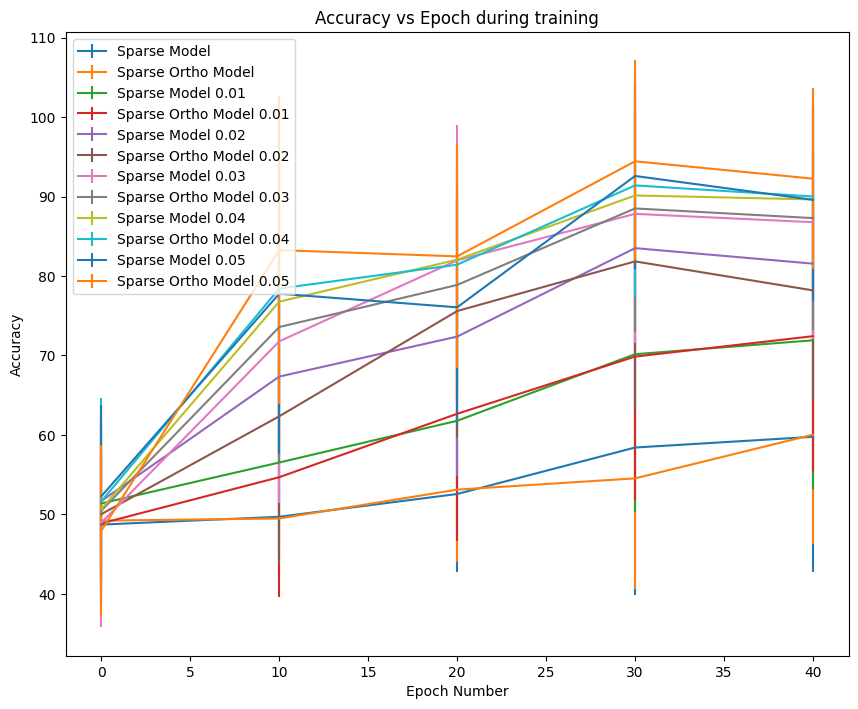

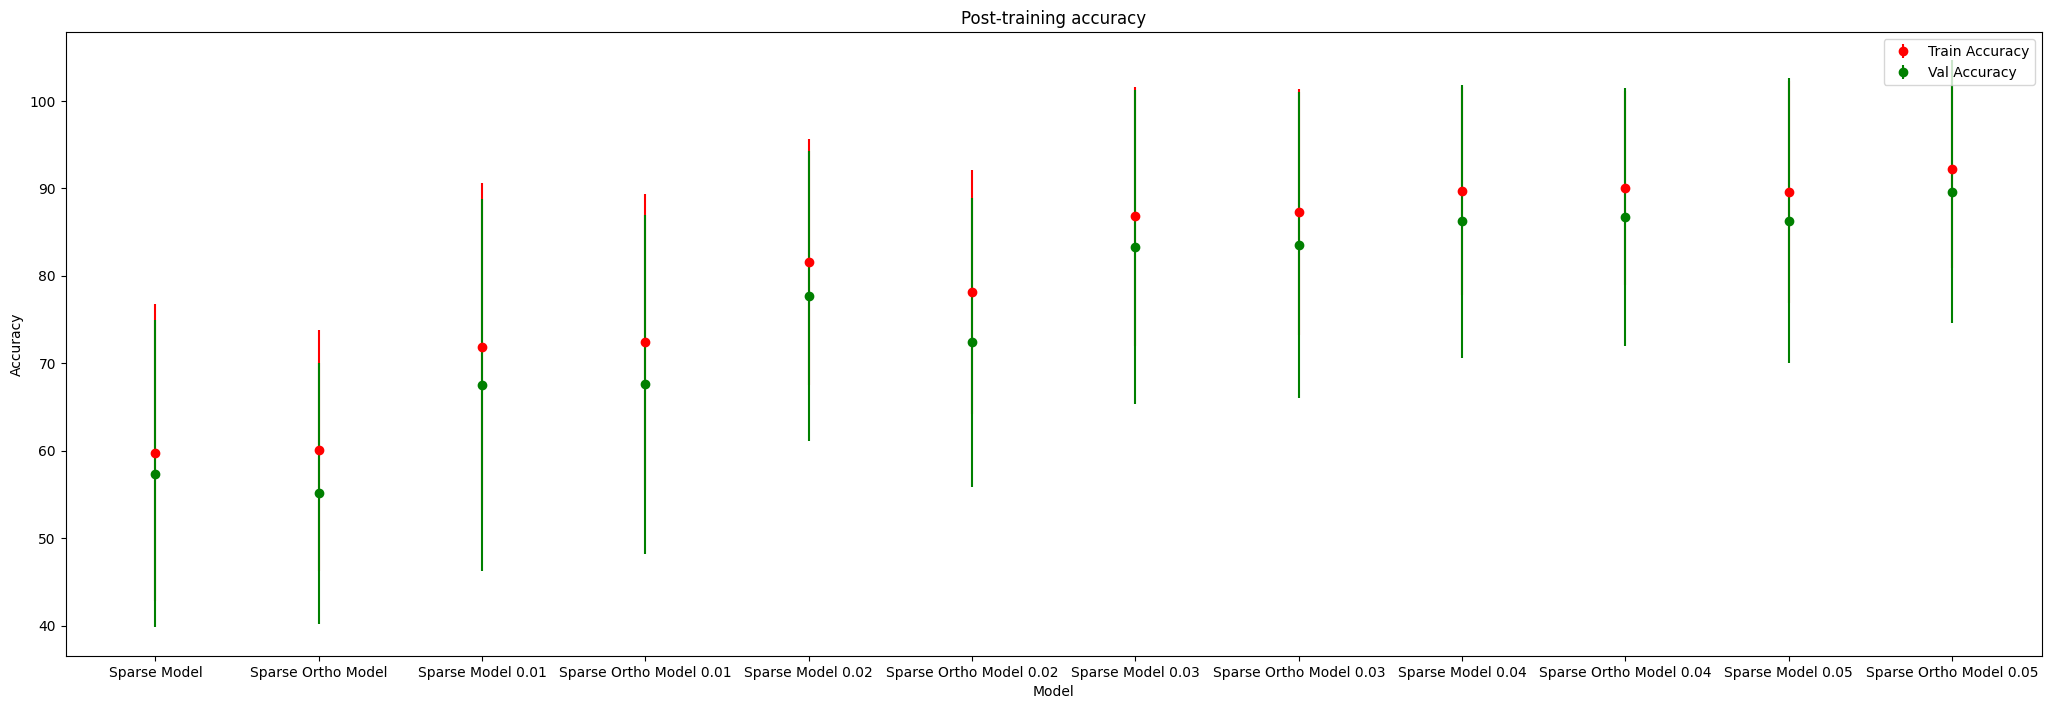

In [78]:
sparse_models = [ i  for i in combined_charts.get_models() if "Sparse" in i]
combined_charts.plot_training_data_for(models=sparse_models).show()
combined_charts.plot_training_data_for(TrainingCharts.ACC, models=sparse_models).show()
combined_charts.plot_test_accu_for_models(models=sparse_models, width_alpha=2.5).show()

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42824/3473151567.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_training_data_for(models=sparse_models).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42824/3473151567.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_training_data_for(TrainingCharts.ACC, models=sparse_models).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42824/3473151567.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_test_accu_for_models(models=sparse_models, width_alpha=2.5).show()


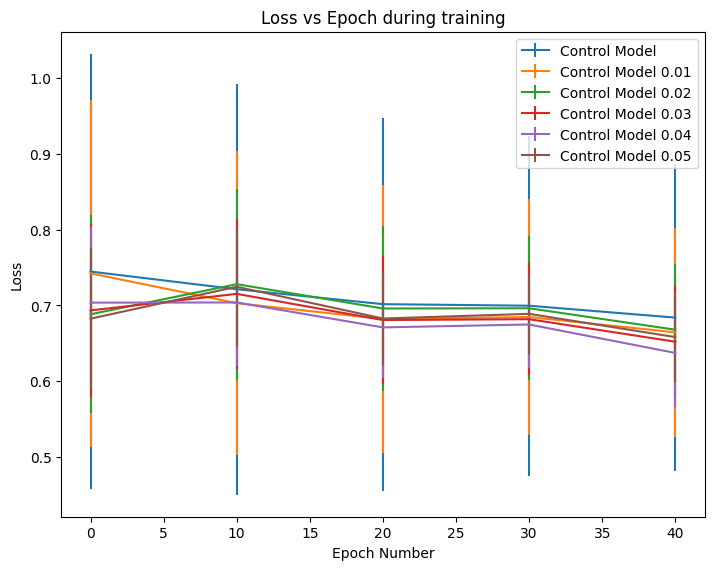

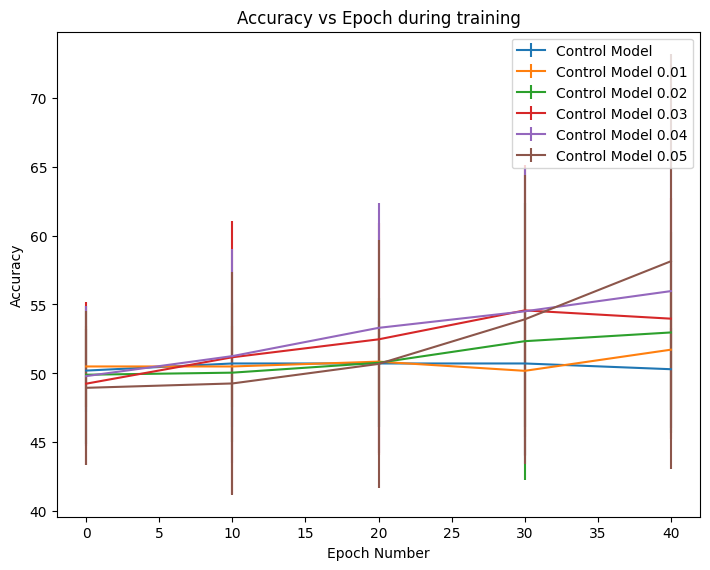

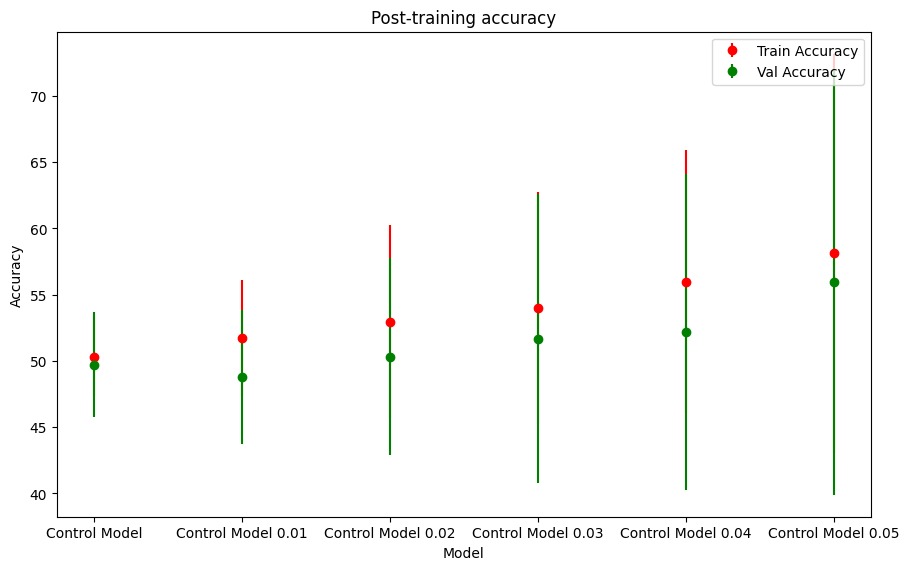

In [79]:
sparse_models = [ i  for i in combined_charts.get_models() if "Control" in i]
combined_charts.plot_training_data_for(models=sparse_models).show()
combined_charts.plot_training_data_for(TrainingCharts.ACC, models=sparse_models).show()
combined_charts.plot_test_accu_for_models(models=sparse_models, width_alpha=2.5).show()

In [ ]:
n_percentages += [0.2, 0.25, 0.3, 0.35, 0.4]
for i in n_percentages:
    chart_utils[i] = perform_one_experiment(first_layer_out_percentage_allowed=i,
                                            second_layer_out_percentage_allowed=i,
                                            third_layer_out_percentage_allowed=i,
                                            print_summary=False)

In [36]:
combined_charts = chart_utils[n_percentages[0]]
for i in n_percentages[1:]:
    combined_charts = combined_charts.combine_charts(chart_utils[i], suffix=f" {i}")

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42824/1153898666.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_training_data_for(models=sparse_models).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42824/1153898666.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_training_data_for(TrainingCharts.ACC, models=sparse_models).show()
/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_42824/1153898666.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_charts.plot_test_accu_for_models(models=sparse_models, width_alpha=2.5).show()


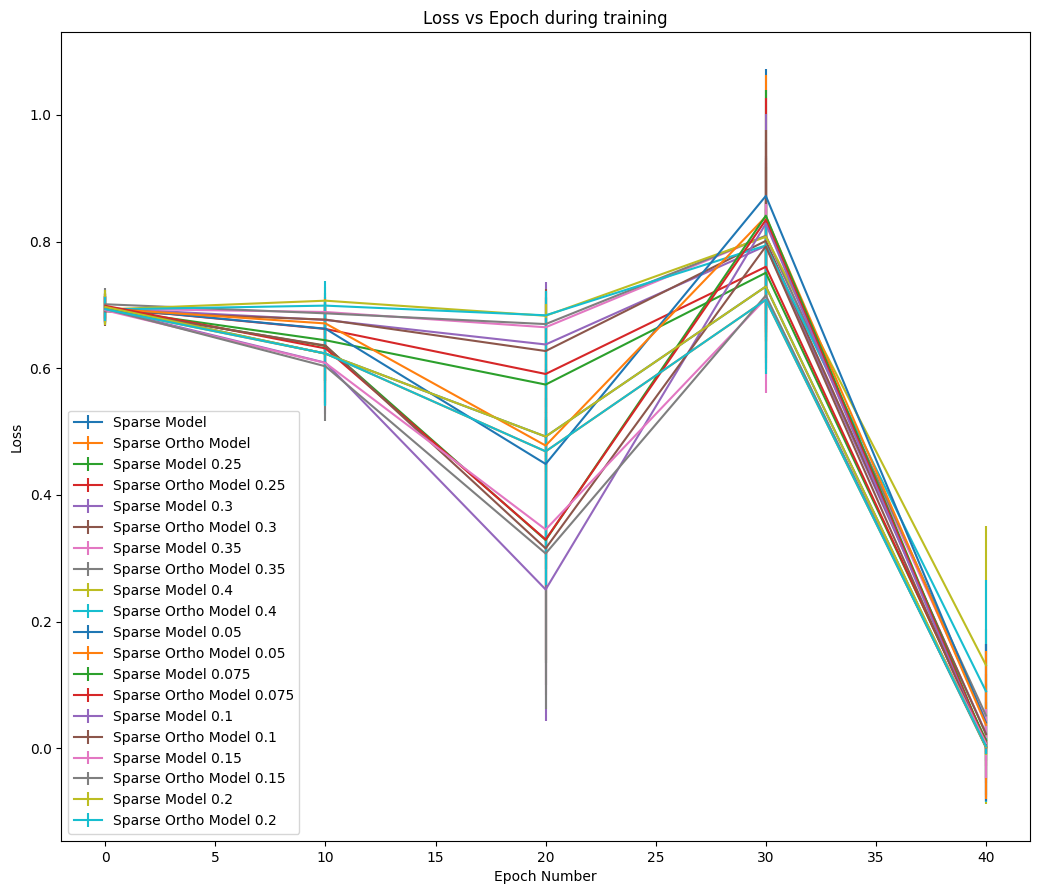

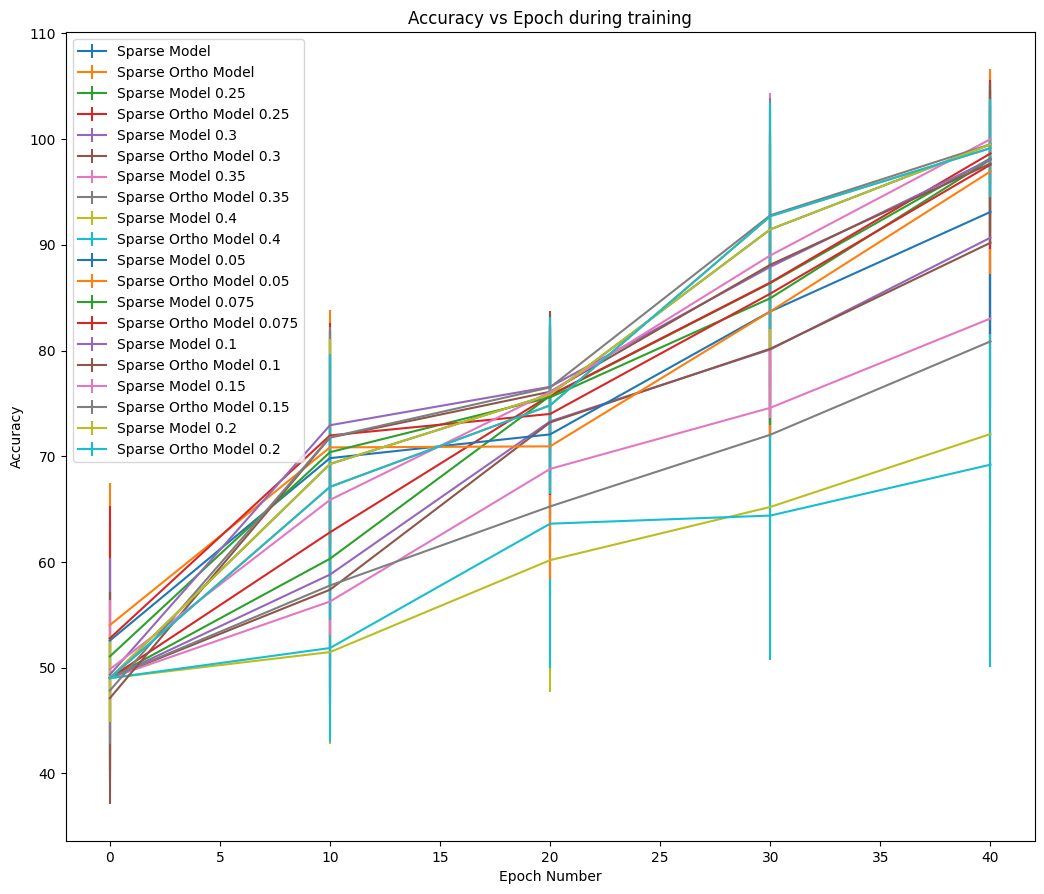

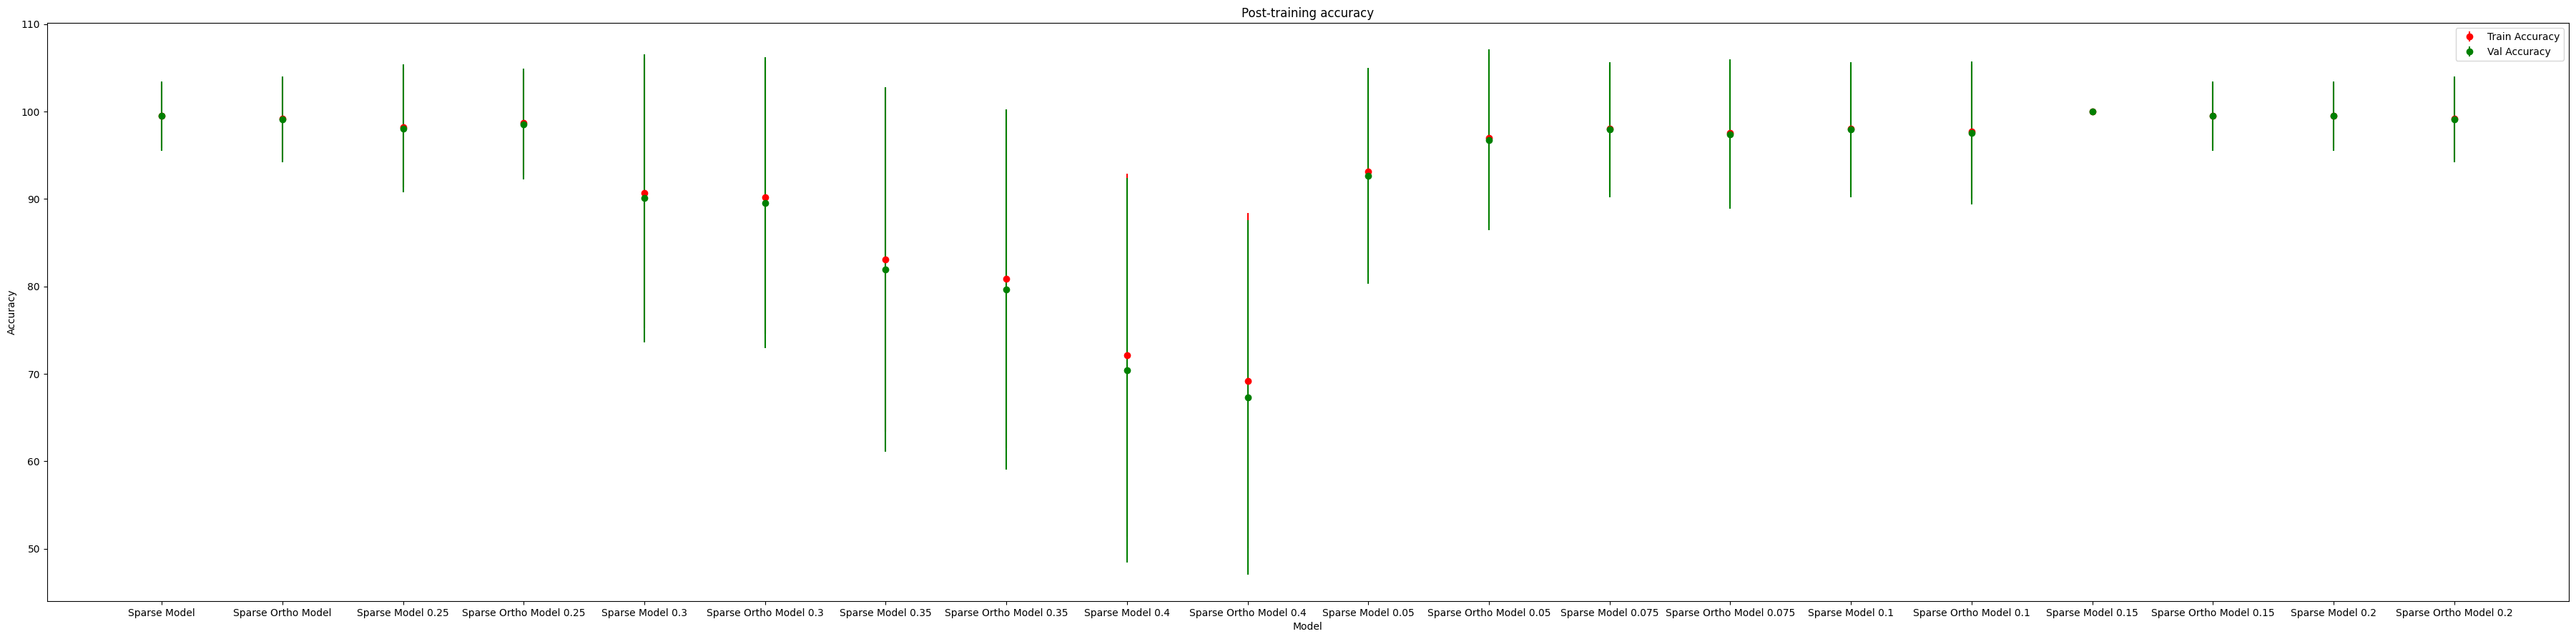

In [37]:
sparse_models = [ i  for i in combined_charts.get_models() if "Sparse" in i]
combined_charts.plot_training_data_for(models=sparse_models).show()
combined_charts.plot_training_data_for(TrainingCharts.ACC, models=sparse_models).show()
combined_charts.plot_test_accu_for_models(models=sparse_models, width_alpha=2.5).show()